# Segmentation d'image par K-means

Ce notebook présente une méthode de segmentation d'images en utilisant le clustering. Nous cherchons à regrouper les pixels ayant des intensités similaires pour simplifier l'image et en extraire les structures principales.

## Import

In [1]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path

# Chargement et préparation des données

Le chargement des données se fait en deux étapes. D'abord, nous récupérons les étiquettes depuis un fichier CSV. Ensuite, nous utilisons une fonction personnalisée pour lire les images.

In [4]:
Y_train = pd.read_csv("./data/Y_train.csv", index_col=0).T
Y_train = Y_train.iloc[:200, :]
Y_train.shape

(200, 262144)

In [24]:
def load_dataset(dataset_dir):
    dataset_list = []
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

X_train = load_dataset("./data/X_train/images/")
X_train.shape

(1000, 512, 512)

## Test sur une image

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tqdm

Pour segmenter une image efficacement, il faut définir le nombre de groupes de pixels (K). Nous testons ici plusieurs valeurs de K allant de 2 à 15.

L'algorithme K-means cherche à minimiser l'inertie, c'est-à-dire la distance entre les pixels et le centre de leur groupe. Plus l'inertie est faible, plus les groupes sont homogènes. Cependant, augmenter K réduit toujours l'inertie. Nous cherchons donc le "coude" dans la courbe, là où l'ajout d'un cluster n'apporte plus d'amélioration significative.

In [ ]:
# Sélection de la première image pour le test
image = X_train[0]
image = image.flatten()

# Liste des valeurs de K à tester
n_clusters = list(range(2, 15 + 1, 1))
inertias = []

# Calculer l'inertie pour chaque K
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image.reshape(-1, 1))
    inertias.append(kmeans.inertia_)

# Calculer les différences normalisées entre inerties successives
diffs = np.diff(inertias)
diffs_ratio = diffs[:-1] / diffs[1:]

# Trouver l'indice du "coude" (où la différence est maximale)
elbow_index = np.argmax(diffs_ratio) + 2  # +2 car diffs_ratio commence à k=3
optimal_k = n_clusters[elbow_index]

print(f"Nombre optimal de clusters (K) : {optimal_k}")

Nombre optimal de clusters (K) : 7


La visualisation permet de confirmer le choix du nombre de clusters. Le premier graphique montre la chute de l'inertie totale. Le second graphique montre la variation de cette chute. Le point le plus haut du second graphique indique mathématiquement l'emplacement du coude, validant ainsi la valeur optimale de K pour notre segmentation.

100%|██████████| 14/14 [00:02<00:00,  6.51it/s]


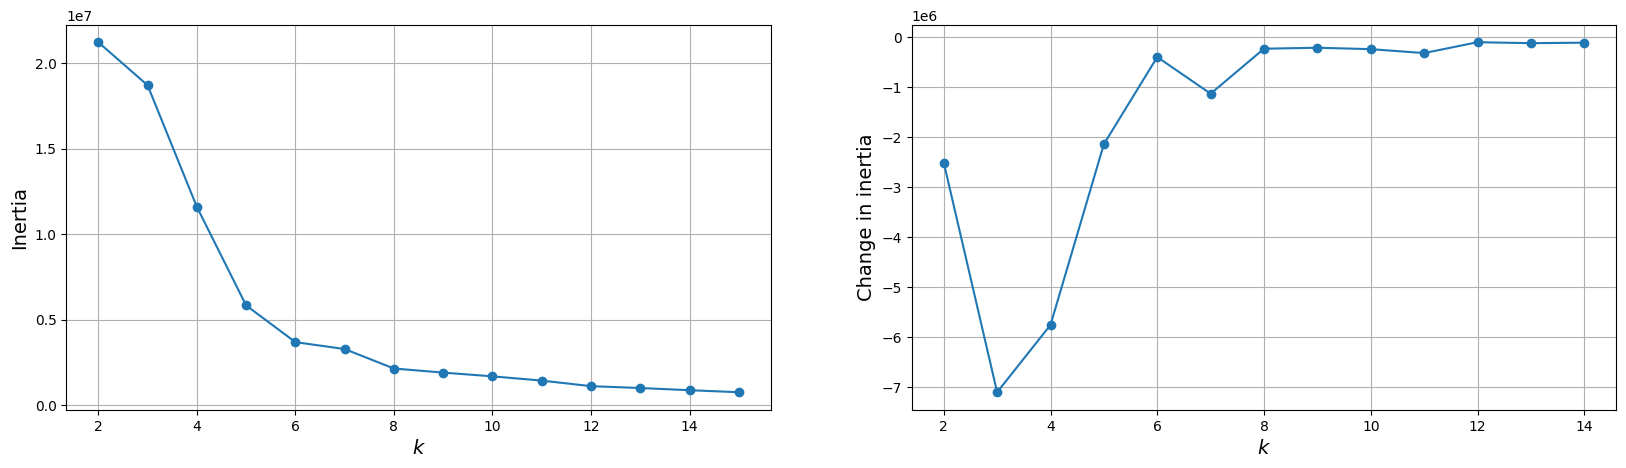

In [ ]:
# Visualisation de l'inertie et de son changement
n_clusters = list(range(2, 15 + 1, 1))
kmeans = []
inertias = []
for i in tqdm.trange(len(n_clusters)):
    kmeans.append(KMeans(n_clusters = n_clusters[i], 
                         random_state = 42))
    kmeans[-1].fit(image.reshape(-1, 1))
    inertias.append(kmeans[-1].inertia_)
plt.figure(figsize = [20, 5])
plt.subplot(1, 2, 1)
plt.plot(n_clusters, inertias, "-o")
plt.xlabel("$k$", fontsize = 14)
plt.ylabel("Inertia", fontsize = 14)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(n_clusters[:-1], np.diff(inertias), "-o")
plt.xlabel("$k$", fontsize = 14)
plt.ylabel("Change in inertia", fontsize = 14)
plt.grid(True)
plt.show()

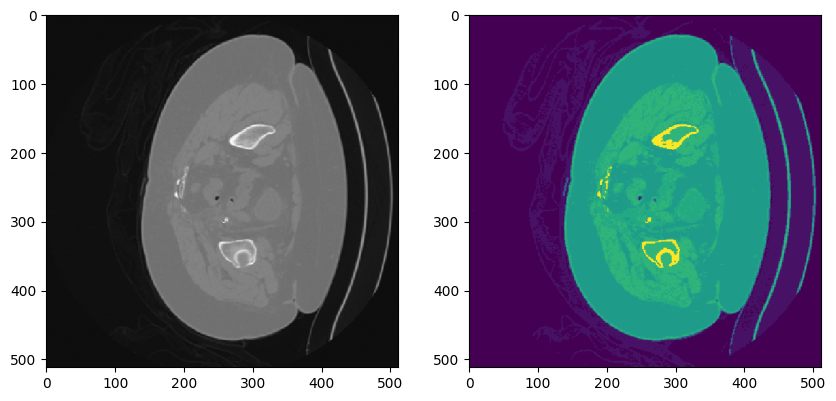

In [ ]:
# Application de K-means avec le K optimal
kmeans = KMeans(n_clusters = 7, random_state = 42)
kmeans.fit(image.reshape(-1, 1))
# Reconstruction de l'image segmentée
X_kmeans = kmeans.cluster_centers_[kmeans.predict(image.reshape(-1, 1))]
X_kmeans = X_kmeans.astype("uint8")
# Affichage de l'image originale et de l'image segmentée
img_kmeans = X_kmeans.reshape(512, 512)
plt.figure(figsize = [10, 10])
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(512, 512), cmap = "gray")
plt.subplot(1, 2, 2)
plt.imshow(img_kmeans)
plt.show()

Calculons maintenant le score obtenu sur cette image.

In [ ]:
# Création d'un DataFrame avec l'image segmentée
df_img_kmeans = pd.DataFrame(img_kmeans.flatten())

In [ ]:
import sklearn.metrics

# Fonction pour calculer le rand index moyen sur un dataset
def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(sklearn.metrics.adjusted_rand_score(labels, preds))

    return np.mean(individual_rand_index)

In [ ]:
# Calcul du rand index entre l'image segmentée et le masque de vérité terrain
y_true = pd.DataFrame(Y_train.iloc[0].values.reshape(-1, 1))
rand_index_dataset(y_true.T, df_img_kmeans.T)

np.float64(0.10802470425002339)

## Test sur tout le dataset

Après avoir déterminé la valeur optimale de $K$, nous appliquons l'algorithme sur un échantillon d'images. 

In [31]:

# Initialisation
n_images = 500
n_clusters_range = list(range(2, 16))
images_traitees = np.zeros((n_images, 512 * 512), dtype=np.uint8)

for i in range(n_images):
    img = X_train[i]
    img_flat = img.flatten().reshape(-1, 1)

    # Calcul des inerties pour tous les k
    inertias = []
    for k in n_clusters_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(img_flat)
        inertias.append(kmeans.inertia_)

    # Méthode du coude
    diffs = np.diff(inertias)
    diffs_ratio = diffs[:-1] / diffs[1:]
    elbow_index = np.argmax(diffs_ratio) + 2
    optimal_k = n_clusters_range[elbow_index]

    # KMeans avec k optimal
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(img_flat)
    X_kmeans = kmeans.cluster_centers_[kmeans.predict(img_flat)]
    images_traitees[i, :] = X_kmeans.astype(np.uint8).flatten()

# Créer le DataFrame avec la shape (10, 262144)
y_pred_kmeans = pd.DataFrame(images_traitees)

print(y_pred_kmeans.shape)  # (10, 262144)


(500, 262144)


Pour mesurer la qualité de notre segmentation, nous utilisons l'Indice de Rand Ajusté (ARI). Ce score compare les groupes trouvés par K-means avec la segmentation réelle fournie dans les données d'entraînement. Un score proche de 1 indique une segmentation presque parfaite, tandis qu'un score proche de 0 indique un regroupement aléatoire.

In [32]:
y_pred_kmeans = pd.DataFrame(images_traitees)
# Select the ground truth for the first 10 images and reshape to match prediction
y_true = Y_train.iloc[:10, :].reset_index(drop=True)
rand_index_dataset(y_true, y_pred_kmeans)

np.float64(0.19095706651810546)